In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the data first (without parsing dates in read_csv)
df = pd.read_csv(
    r"D:\Data Science\Projects\Power Pulse\Individual Household Electric Power Consumption.csv", 
    sep=',', # Use ',' if your CSV is comma-separated, or ';' if it's the original UCI format
    low_memory=False, 
    na_values=['?']
)

# 2. Combine Date and Time and convert to datetime explicitly
# The format '%d-%m-%Y %H:%M:%S' matches the warning you received
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H:%M:%S')

# 3. Set the datetime as index and drop original columns
df.set_index('datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

# 4. Handle missing values and ensure numeric types
df.ffill(inplace=True) # Recommended for time series
for col in df.columns:
    df[col] = pd.to_numeric(df[col])

# Basic EDA check
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1048575 entries, 2006-12-16 17:24:00 to 2008-12-13 21:38:00
Data columns (total 8 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1048575 non-null  int64  
 1   Global_active_power    1048575 non-null  float64
 2   Global_reactive_power  1048575 non-null  float64
 3   Voltage                1048575 non-null  float64
 4   Global_intensity       1048575 non-null  float64
 5   Sub_metering_1         1048575 non-null  float64
 6   Sub_metering_2         1048575 non-null  float64
 7   Sub_metering_3         1048575 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 72.0 MB
None


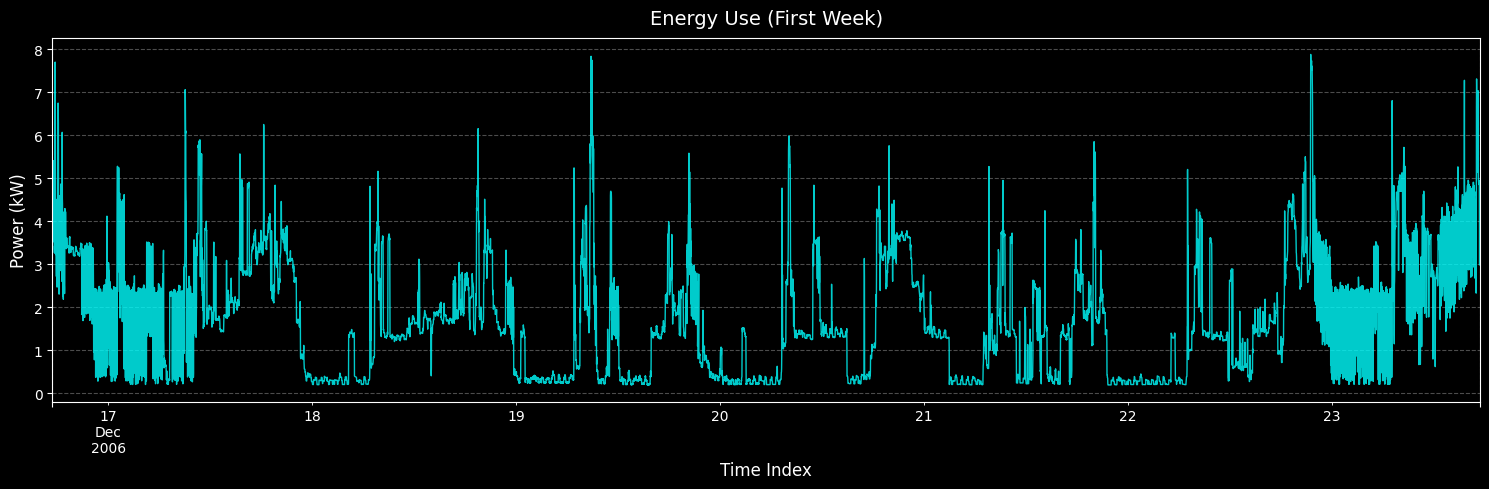

In [2]:
# Visualize Energy Usage (First week)
import matplotlib.pyplot as plt

# Set dark theme globally
plt.style.use('dark_background')

# Plot the first week (10080 minutes)
plt.figure(figsize=(15, 5))
df['Global_active_power'].head(10080).plot(
    color='cyan',  # Use a high-contrast color for visibility
    linewidth=1,
    alpha=0.8
)

# Customizing layout for dark mode
plt.title('Energy Use (First Week)', fontsize=14, pad=10)
plt.xlabel('Time Index', fontsize=12)
plt.ylabel('Power (kW)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)  # Subtle grid for dark backgrounds

plt.tight_layout()
plt.show()


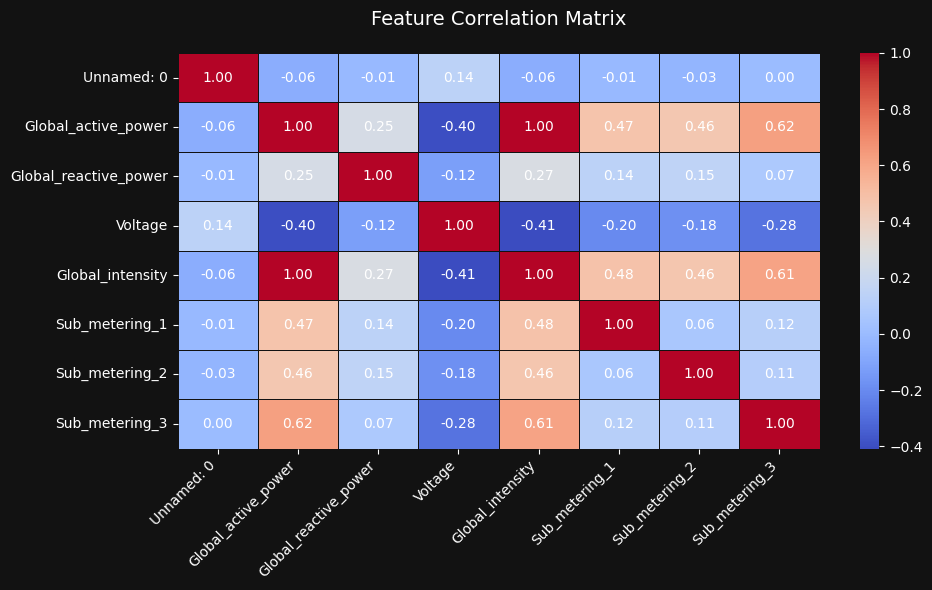

In [3]:
# Correlation Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

# Set the dark theme globally
plt.style.use('dark_background')

# Set figure size and create the heatmap
plt.figure(figsize=(10, 6), facecolor='#121212') # Deep dark background

# Plotting with specific dark-mode enhancements
sns.heatmap(
    df.corr(), 
    annot=True, 
    cmap='coolwarm',     # Standard for correlation, but works well in dark mode
    fmt=".2f",           # Clean formatting for 2 decimal places
    linewidths=0.5,      # Adds a subtle grid between cells
    linecolor='#121212', # Matches the background for a "cutout" effect
    annot_kws={"size": 10, "color": "white"} # Ensures annotations are visible
)

# Customizing titles and labels for 2026 standards
plt.title("Feature Correlation Matrix", fontsize=14, pad=20, color='white')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


In [4]:
# Handle missing values by dropping them (or use df.fillna(method='ffill'))
df.dropna(inplace=True)

# Ensure all columns are numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col])

# Create Rolling Averages (e.g., 60-minute window)
df['rolling_mean_60'] = df['Global_active_power'].rolling(window=60).mean()
df.dropna(inplace=True) # Drop new NaNs from rolling window


In [5]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

# Define Features and Target
FEATURES = ['Global_reactive_power', 'Voltage', 'Global_intensity', 
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 
            'hour', 'dayofweek', 'month', 'rolling_mean_60']
TARGET = 'Global_active_power'

X = df[FEATURES]
y = df[TARGET]


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Train-Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1)
}

# Train and Predict
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)
    print(f"{name} trained.")


Linear Regression trained.
Random Forest trained.
XGBoost trained.


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

results = []
for name, pred in predictions.items():
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    results.append({"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2})

# Display Results
results_df = pd.DataFrame(results)
print("\nModel Evaluation Metrics:")
print(results_df)



Model Evaluation Metrics:
               Model      RMSE       MAE        R2
0  Linear Regression  0.041788  0.026598  0.998635
1      Random Forest  0.035356  0.019702  0.999023
2            XGBoost  0.030341  0.017605  0.999280


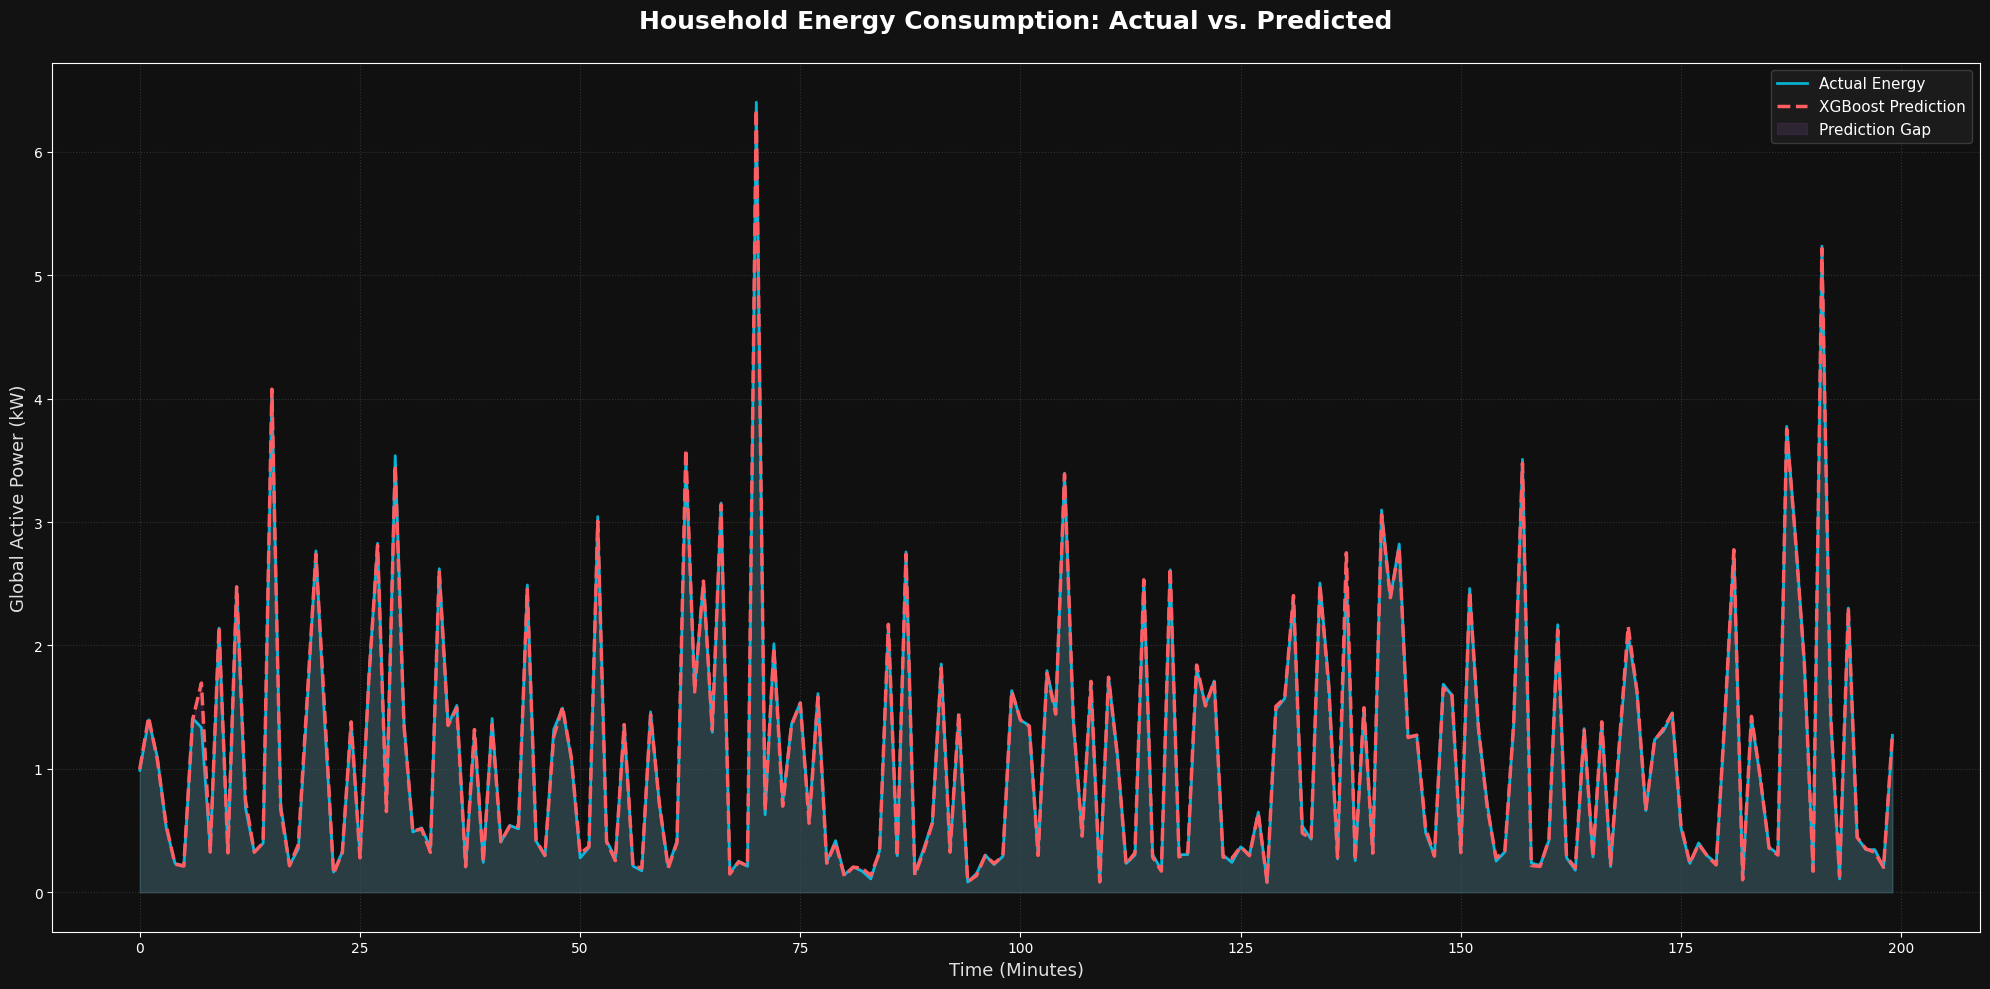

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Apply the global dark background style
plt.style.use('dark_background') 

# Set figure size and a custom deep-grey background for the outer area
plt.figure(figsize=(20, 10), facecolor='#121212')
ax = plt.gca()
ax.set_facecolor("#101010") # Slightly lighter grey for the inner plot area

# Data slicing (Ensure y_test is a series/array and predictions is a dict/dataframe)
actual = y_test.values[:200]
pred = np.asarray(predictions['XGBoost'])[:200]
time_range = range(len(actual))

# 1. Plot Actual Energy (Neon Blue for high contrast)
plt.plot(time_range, actual, label='Actual Energy', color="#00d5ff", linewidth=2, alpha=0.8)
plt.fill_between(time_range, actual, color="#63a8b7", alpha=0.3)

# 2. Plot XGBoost Prediction (Vibrant Sunset Orange)
plt.plot(time_range, pred, label='XGBoost Prediction', color='#ff5e62', 
         linestyle='--', linewidth=2.5, alpha=1)

# 3. Fill the Error Gap (Subtle Purple/Grey to see overlaps clearly)
plt.fill_between(time_range, actual, pred, color='#9b59b6', alpha=0.15, label='Prediction Gap')

# Styling the Text and Labels
plt.title('Household Energy Consumption: Actual vs. Predicted', fontsize=18, fontweight='bold', pad=25, color='#ffffff')
plt.xlabel('Time (Minutes)', fontsize=13, color='#e0e0e0')
plt.ylabel('Global Active Power (kW)', fontsize=13, color='#e0e0e0')

# Grid and Legend adjustments
plt.grid(True, linestyle=':', alpha=0.5, color='#555555')
plt.legend(frameon=True, facecolor='#1e1e1e', edgecolor='#444444', loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()


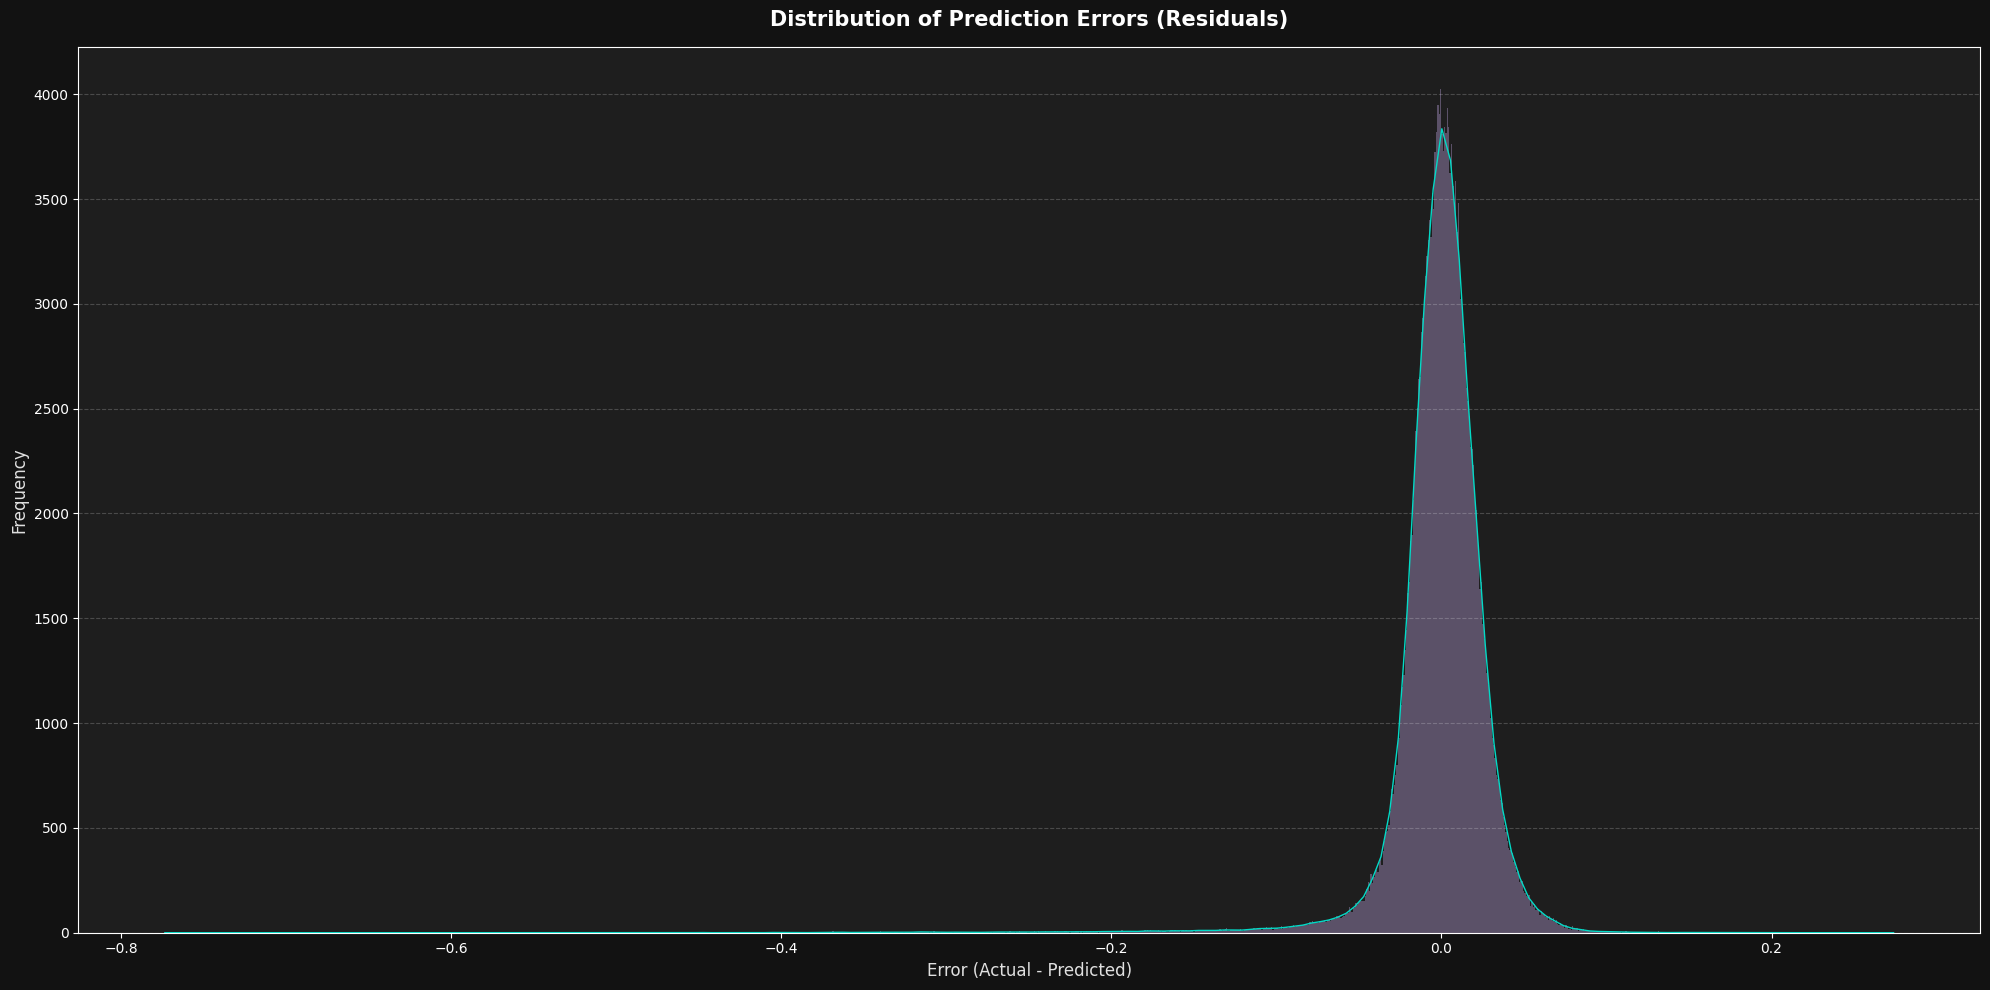

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the dark aesthetic
plt.style.use('dark_background')
plt.figure(figsize=(20, 10), facecolor='#121212')

# Calculate residuals
residuals = y_test - predictions['XGBoost']

# Create the plot
ax = sns.histplot(residuals, kde=True, color="#b9a0d8", alpha=0.4, linewidth=0)

# Customizing the KDE line specifically
line = ax.lines[0]
line.set_color('#03dac6') # Teal line for contrast against purple bars
line.set_linewidth(1)

# Background and Grid tweaks
ax.set_facecolor('#1e1e1e')
plt.grid(axis='y', linestyle='--', alpha=0.2)

# Labels and Title
plt.title('Distribution of Prediction Errors (Residuals)', fontsize=15, fontweight='bold', color='white', pad=15)
plt.xlabel('Error (Actual - Predicted)', fontsize=12, color='#e0e0e0')
plt.ylabel('Frequency', fontsize=12, color='#e0e0e0')

plt.tight_layout()
plt.show()


C:\Users\LORD'S PRABHAKARAN\AppData\Local\Temp\ipykernel_16396\1345074401.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


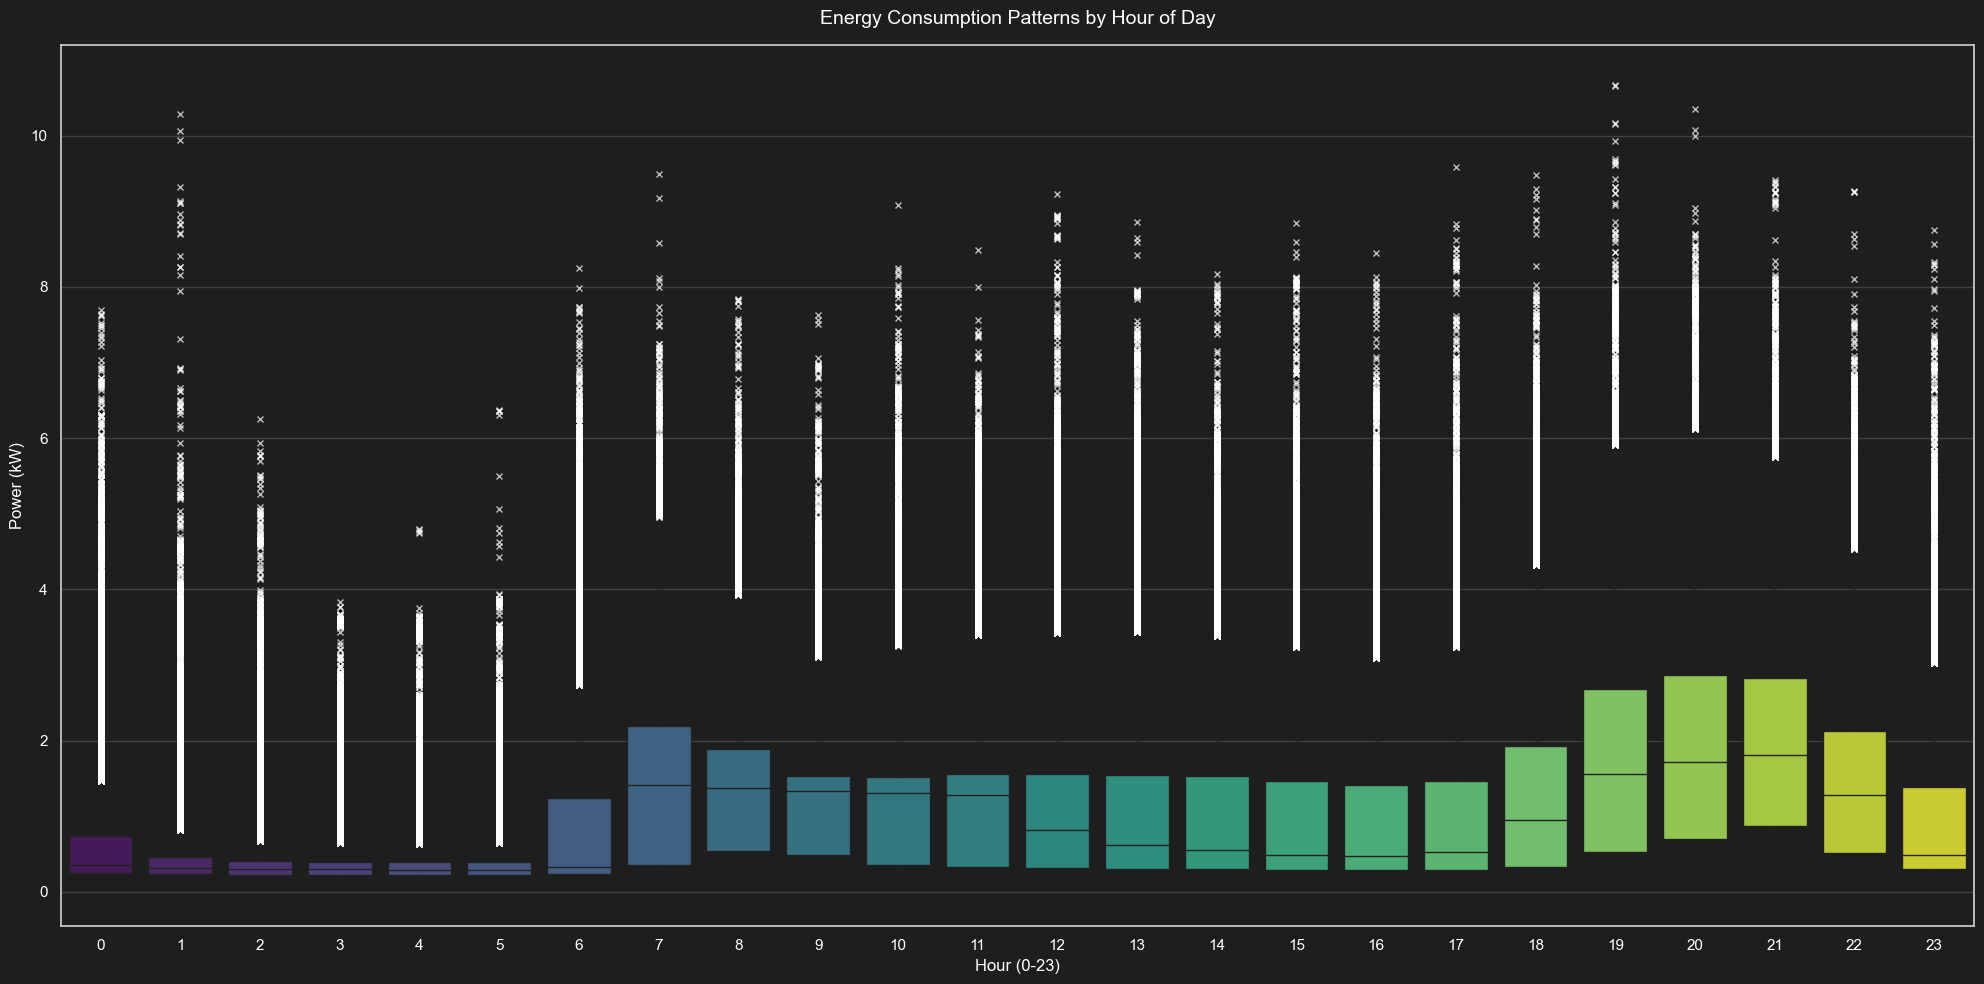

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the dark theme style
plt.style.use('dark_background')
sns.set_theme(style="whitegrid", rc={"axes.facecolor": "#1e1e1e", "figure.facecolor": "#1e1e1e"})

plt.figure(figsize=(20, 10))

# Creating the boxplot with a vibrant palette for contrast
sns.boxplot(
    x='hour', 
    y='Global_active_power', 
    data=df, 
    palette='viridis',
    flierprops={"marker": "x", "markersize": 4, "markeredgecolor": "white", "markerfacecolor": "white", "alpha": 0.7}
)

# Customizing labels and title
plt.title('Energy Consumption Patterns by Hour of Day', fontsize=14, pad=15, color='white')
plt.xlabel('Hour (0-23)', fontsize=12, color='white')
plt.ylabel('Power (kW)', fontsize=12, color='white')
plt.xticks(color='white')
plt.yticks(color='white')

# Adjusting grid transparency for better visibility
plt.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.show()
